In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.applications import VGG16

In [ ]:
import os
import cv2
import numpy as np

# Data preparation
train_dir = '../input/face-expression-recognition-dataset/images/train/'
test_dir = '../input/face-expression-recognition-dataset/images/validation/'

list_files_name = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

# Define the number of samples you want to use from each class for training and testing
num_samples_per_class = 50

# Define the directories for training and testing for each emotion
dir_list_train = [os.path.join(train_dir, emotion) for emotion in list_files_name]
dir_list_test = [os.path.join(test_dir, emotion) for emotion in list_files_name]

# Load and preprocess the limited number of training data
def load_limited_images_from_directory(directory, num_samples):
    images = []
    labels = []
    for label, emotion in enumerate(list_files_name):
        emotion_dir = os.path.join(directory, emotion)
        file_list = os.listdir(emotion_dir)[:num_samples]
        for filename in file_list:
            img = cv2.imread(os.path.join(emotion_dir, filename))
            img = cv2.resize(img, (48, 48))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
            img = img / 255.0  # Normalize pixel values

            # Create granules for the image
            granules = []
            for i in range(0, img.shape[0], 7):
                for j in range(0, img.shape[1], 7):
                    granule = img[i:i+7, j:j+7]
                    granules.append(granule)

            images.extend(granules)  # Extend the list of images with granules
            labels.extend([label] * len(granules))  # Extend labels accordingly

    return np.array(images), np.array(labels)

# Load limited training data with granules
x_train, y_train = load_limited_images_from_directory(train_dir, num_samples_per_class)

# Load limited testing data with granules
x_test, y_test = load_limited_images_from_directory(test_dir, num_samples_per_class)

# Now, x_train and x_test contain granules, and y_train and y_test contain the corresponding labels.


/tmp/ipykernel_32/1707798721.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


In [ ]:
print(len(x_train), len(y_train))



17150 17150


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to resize granules
def resize_granules(granules):
    resized_granules = []
    for granule in granules:
        resized_granule = cv2.resize(granule, (224, 224))
        resized_granules.append(resized_granule)
    return np.array(resized_granules)

# Resize granules for training and testing
resized_granules_train = resize_granules(granules_train)
resized_granules_test = resize_granules(granules_test)

# Reshape the granules into appropriate 4-dimensional arrays
resized_granules_train = resized_granules_train.reshape(-1, 224, 224, 3)
resized_granules_test = resized_granules_test.reshape(-1, 224, 224, 3)

# Function to extract features from granules using VGG16
def extract_features(granules):
    features = []
    for granule in granules:
        feature = vgg.predict(np.expand_dims(granule, axis=0))
        features.append(feature)
    return np.array(features)

# Extract features for training and testing
features_train = extract_features(resized_granules_train)
features_test = extract_features(resized_granules_test)

# Print VGG16 model summary
vgg.summary()

# Now, features_train and features_test contain the extracted features from the granules.


1/1 [==============================] - 0s 301ms/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_

In [ ]:
print(len(features_train), len(features_test))

112 112


In [ ]:
def func1(features_train, features_test):
    # feature aggregation
    aggregated_features_train = np.mean(features_train, axis=0)
    aggregated_features_test = np.mean(features_test, axis=0)

    print("Feature aggregation completed.")
    return aggregated_features_train, aggregated_features_test

aggregated_features_train, aggregated_features_test = func1(features_train, features_test)


Feature aggregation completed.


In [ ]:
features_train.shape
aggregated_features_train.shape


(1, 7, 7, 512)

In [ ]:
# Reshape features_train and features_test
features_train = np.reshape(features_train, (112, 7, 7, 512))
features_test = np.reshape(features_test, (112, 7, 7, 512))
features_train.shape


(112, 7, 7, 512)

In [ ]:
keras.utils.to_categorical(y_train)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Dense

model = Sequential()

# 1st Convolution layer
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(7, 7, 512)))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# 2nd Convolution layer
model.add(Dense(128, activation='relu'))  # Added Dense layer instead of Conv2D
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure that the labels are one-hot encoded for categorical_crossentropy loss
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Adjust the labels to match the number of granules
num_granules = len(features_train)
y_train_adjusted = y_train_encoded[:num_granules]

# Train the model using the extracted features and adjusted labels
history = model.fit(features_train, y_train_adjusted, epochs=30, batch_size=32)
# Save the training history for plotting
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Print model summary
model.summary()


Epoch 1/30
4/4 [==============================] - 2s 86ms/step - loss: 2.6106 - accuracy: 0.1429
Epoch 2/30
4/4 [==============================] - 0s 89ms/step - loss: 2.4492 - accuracy: 0.2054
Epoch 3/30
4/4 [==============================] - 0s 85ms/step - loss: 2.3669 - accuracy: 0.1786
Epoch 4/30
4/4 [==============================] - 0s 87ms/step - loss: 2.3966 - accuracy: 0.1250
Epoch 5/30
4/4 [==============================] - 0s 84ms/step - loss: 2.2791 - accuracy: 0.2054
Epoch 6/30
4/4 [==============================] - 0s 85ms/step - loss: 2.2486 - accuracy: 0.2679
Epoch 7/30
4/4 [==============================] - 0s 85ms/step - loss: 2.2517 - accuracy: 0.2589
Epoch 8/30
4/4 [==============================] - 0s 84ms/step - loss: 2.1055 - accuracy: 0.2768
Epoch 9/30
4/4 [==============================] - 0s 84ms/step - loss: 1.9985 - accuracy: 0.3393
Epoch 10/30
4/4 [==============================] - 0s 88ms/step - loss: 2.0105 - accuracy: 0.3125
Epoch 11/30
4/4 [============

In [ ]:
len(features_test)
len(keras.utils.to_categorical(y_test))

17150

In [ ]:
import matplotlib.pyplot as plt

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Adjust the labels to match the number of granules in the test set
num_granules_test = len(features_test)
y_test_adjusted = y_test_encoded[:num_granules_test]

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(features_test, y_test_adjusted, verbose=0)
print('Test accuracy:', test_acc)
print("Test Loss", test_loss)



Test accuracy: 0.9821428656578064
Test Loss 0.5651155114173889


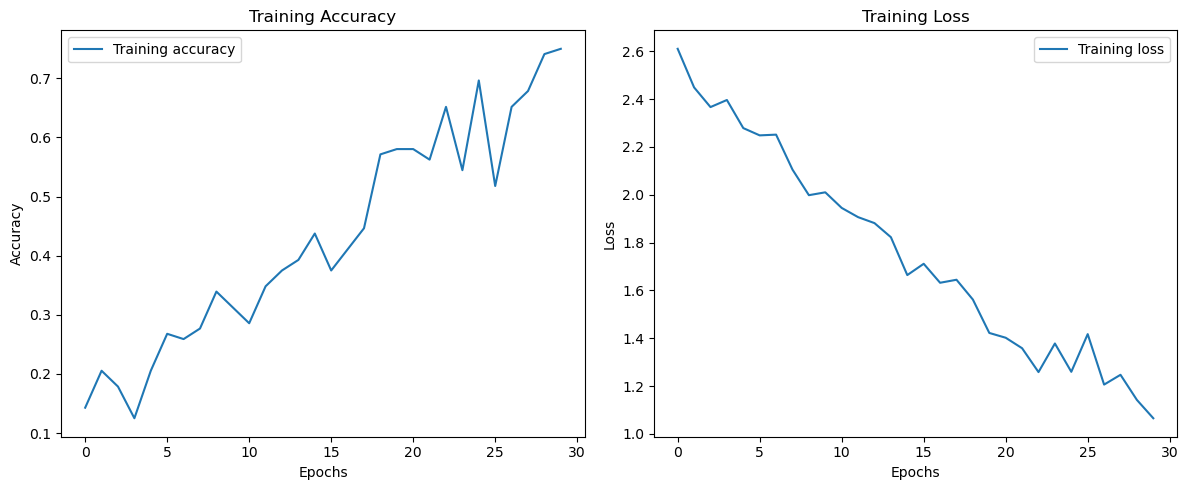

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the variables training_accuracy and training_loss

# Plot training accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
